# Cardiac Arrythmia prediction using machine learning

The goal of this project is to classify whether the patient has “normal” or “abnormal” heart sound from the Phonocardiogram (PCG) or heartbeat recordings to quickly identify patients who would require further diagnosis. This is a supervised learning problem since we already know if the heart sound in training dataset is normal or abnormal. The basic idea is to convert each heart sound recording(wav file) to a spectrogram image and train a Convolutional Neural Network over those images. Then given a new ECG recording, we will be able to classify it as normal or abnormal.

Since the data we have is limited hence we have used flow_from_directory keras function. To use this function we will have to divide the dataset into test and validation set into seperate folders. This was done manually in ratio of 75%:25%. We have used shuf unix command to randomly select images from the dataset folder. Hence now we have data stored in two subfolders train and valid.

    train_dir/
        normal/
            img.png
            img.png
            ...
        abnormal/
            img.png
            img.png
            ...
    valid_dir/
        normal/
            img.png
            img.png
            ...
        abnormal/
            img.png
            img.png
            ...

In [1]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Exploration

The heartbeat recording can be downloaded from [here](https://physionet.org/physiobank/database/challenge/2016/). The dataset contains about 3500 recording. After converting the .wav recordings into spectrogram images(using convert.py python script), the training dataset has 800 images (of which 400 belong to abnormal and 600 to normal class) and test set contains around 225 images(80 of abnormal and rest belong to normal class).

The model (Convolutional Neural Network) takes images as input. So we first need to convert the recordings into spectrogram images. This is taken care by 'convert_to_spectrogram.py' which is present in the same repostiory as this notebook. Hence before experimenting with this notebook, it is required to run 'convert_to_spectrogram.py'.

### Exploring the dataset and a brief introduction to Spectrograms

Here lets see what the spectrogram images after converting from .wav recording look like. 

Spectrograms are a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a waveform. They are also used to see how energy levels vary over time. They are basically two-dimensional graphs, with a third dimension represented by colors. Time runs from left (oldest) to right (youngest) along the horizontal axis. The vertical axis represents frequency, which can also be thought of as pitch or tone, with the lowest frequencies at the bottom and the highest frequencies at the top.  The amplitude (or energy or “loudness”) of a particular frequency at a particular time is represented by the third dimension, color, with dark blues corresponding to low amplitudes and brighter colors up through red corresponding to progressively stronger (or louder) amplitudes.

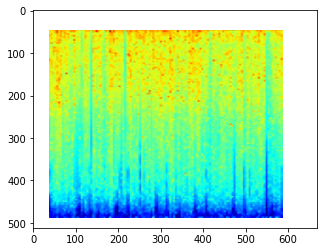

In [2]:
img = cv2.imread('data/train/normal/b0143.png')
plt.imshow(img)

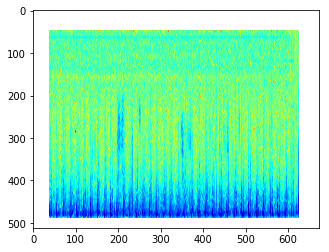

In [4]:
img = cv2.imread('train_dir/abnormal/a0117.png')
plt.imshow(img)

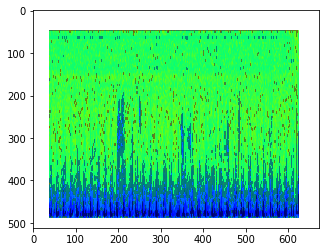

In [5]:
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]
plt.imshow(img2)

This is how the spectogram looks like after doing the **histogram bias correction**. This technique when applied on the image enhances the edges. We don't know wheather the cnn model will give a better accuracy on this preprocessed image, hence we will train our model on both set of images.

### Zoomed version of the images

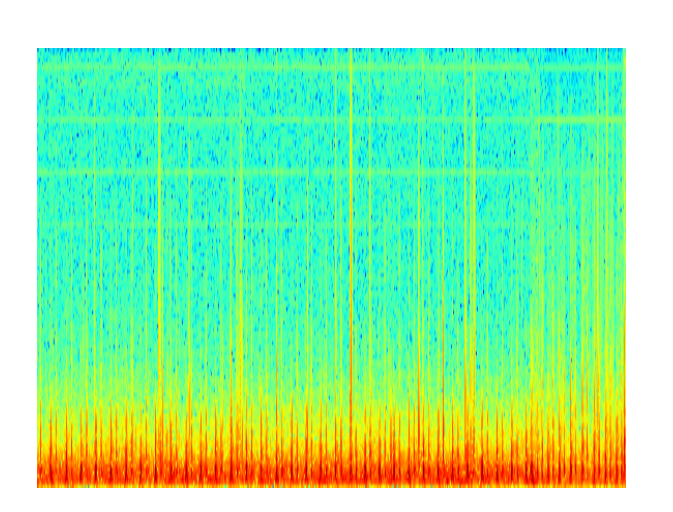

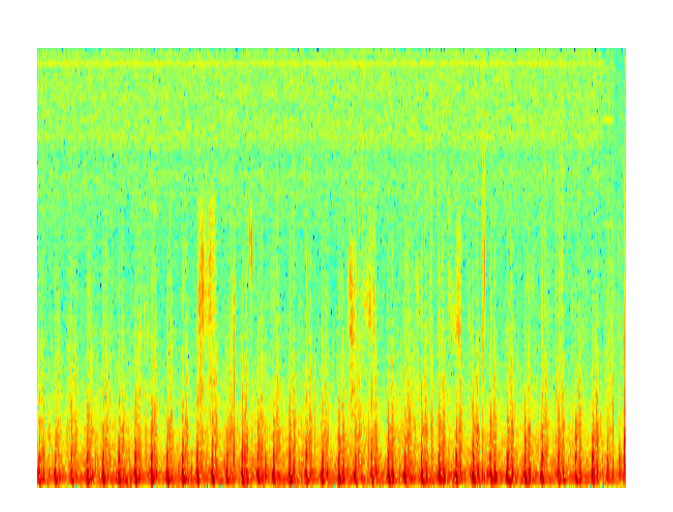

In [8]:
# Dimension for our images
img_width, img_height = 150, 150

from IPython.display import Image
from IPython.display import display

listOfImageNames = ['train_dir/normal/a0408.png',
                   'train_dir/abnormal/a0117.png',
                   ]


for imageName in listOfImageNames:
    display(Image(filename=imageName))

In [9]:
import os

nor_train_dir = 'train_dir/normal/'
abnor_train_dir = 'train_dir/abnormal/'

nor_train = len(next(os.walk(nor_train_dir))[2])
abnor_train = len(next(os.walk(abnor_train_dir))[2])

nor_valid_dir = 'valid_dir/normal/'
abnor_valid_dir = 'valid_dir/abnormal/'

nor_valid = len(next(os.walk(nor_valid_dir))[2])
abnor_valid = len(next(os.walk(abnor_valid_dir))[2])

## We subtract 1 since every directory has a hidden file .DS_Store
print ('Number of samples in training set (normal): {}'.format((nor_train)-1))
print ('Number of samples in training set (abnormal): {}'.format((abnor_train)-1))

print ('Number of samples in validation set (normal): {}'.format((nor_valid)-1))
print ('Number of samples in validation set (abnormal): {}'.format((abnor_valid)-1))

Number of samples in training set (normal): 624
Number of samples in training set (abnormal): 458
Number of samples in validation set (normal): 206
Number of samples in validation set (abnormal): 152


In [10]:
train_data_dir = 'train_dir/'
valid_data_dir = 'valid_dir/'
img_width, img_height = 150, 150

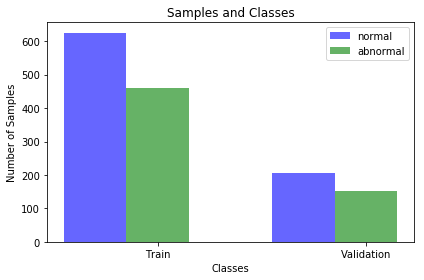

In [11]:
import numpy as np
import matplotlib.pyplot as plt
 
n_groups = 2

train_samples = (nor_train, nor_valid)
validation_samples = (abnor_train, abnor_valid)
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.6
 
rects1 = plt.bar(index, train_samples, bar_width,
                 alpha=opacity,
                 color='b',
                 label='normal')
 
rects2 = plt.bar(index + bar_width, validation_samples, bar_width,
                 alpha=opacity,
                 color='g',
                 label='abnormal')
 
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Samples and Classes')
plt.xticks(index + bar_width, ('Train', 'Validation'))
plt.legend()
 
plt.tight_layout()
plt.show()

### Data augmentation

We see that we don't have enough data. To make our ML model more robust we need more data.So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above)

For our model we would apply four data augmentation techniques as described below :
- Normalize pixel values between 0 and 1. This can be done by setting the 'rescale' attribute to 1/.255
- Appling [shear transformations](https://en.wikipedia.org/wiki/Shear_mapping). Can be done with the 'shear_range' attribute
- Zooming inside images uding 'zoom_range' attribute
- Flipping half of the images horizontally. This is done by setting the 'horizontal_flip' attribute to 'True'

The **ImageDataGenerator'** class has the method 'flow_from_directory'.It takes the path to a directory, and generates batches of augmented data and yields batches in an infinite loop. It further provides us with the number of images in each set.

In [12]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1084 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


### Splitting of dataset

We have used this command to randomly split the normal data in ratio 75:25 for train and valid.

**shuf -zn153 -e \*.png | xargs -0 mv -vt ~/workspace_ml/Cardiac-Arrhythmia-ML/ecg_data/abnormal_valid**


### Evaluation metrics

Evaluating a machine learning algorithm is an essential part of any project. Our model may give us satisfying results when evaluated using a metric say accuracy_score but may give poor results when evaluated against other metrics such as logarithmic_loss or any other such metric. Most of the times we use classification accuracy to measure the performance of our model, however it is not enough to truly judge our model. Hence we will use following metrics to measure our model.
- Accuracy 
- Precision 
- Recall
- f-Beta score

Since Keras only provides us with accuracy,hence we need to write our own custom metrics that can be passed at the compilation step.

In [14]:
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

### Visualisations

It is always better if we are able to see visually how well our model is performing. Hence below we define simple visualisation methods.

In [15]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

### Machine learning models

### Convolutional neural networks(CNN)

CNNs, like neural networks, are made up of neurons with learnable weights and biases. Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and gives  an output. Convolutional Neural Networks take advantage of the fact that the input consists of images (i.e pixels closer together are more meaningful) and this allows us to encode certain properties into the architecture. This means that the forward function is more efficient to implement and hence vastly reduces the amount of parameters in the network. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.

There are 3 types of layers present in Convolutional Neural Networks :
- Convolutional Layers: Convolution is a mathematical operation which is used to filter signals and find patterns in signals etc. In a convolutional layer, all neurons apply convolution operation to the inputs. The convolution layer comprises of a set of independent filters. Each filter is independently convolved with the image and we end up with n feature maps.
- Pooling Layers: This is mostly applied immediately after the convolutional layer to reduce the spatial size(only width and height, not depth). This reduces the number of parameters, hence computation is reduced. Also, less number of parameters avoid overfitting. The most common form of pooling is Max pooling where we take a filter of size n*n and apply the maximum operation over the n*n sized part of the image.
- Fully Connected Layer: This layer just computes the matrix multiplication of inputs recieved from neurons in the previous layer followed by bias offset.

**We will build different cnn models based on their complexity and choose the one which has better performance. **

In [16]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,...)`
  
/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  
/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  


In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [18]:
nb_epoch = 5
nb_train_samples = 1000
nb_validation_samples = 225

We will use fit_generator. One great advantage about fit_generator() besides saving memory is user can integrate random augmentation inside the generator, so it will always provide model with new data to train on the fly.

In [19]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/adityajainkld/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=1000, validation_data=<keras.pre..., epochs=5, validation_steps=225)`
  


Epoch 1/5
1000/1000 [==============================] - 1179s 1s/step - loss: 0.5680 - acc: 0.6990 - precision: 0.7098 - recall: 0.8450 - fbeta_score: 0.7598 - val_loss: 0.5543 - val_acc: 0.7447 - val_precision: 0.7464 - val_recall: 0.8452 - val_fbeta_score: 0.7883
Epoch 2/5
1000/1000 [==============================] - 1167s 1s/step - loss: 0.3970 - acc: 0.8174 - precision: 0.8230 - recall: 0.8744 - fbeta_score: 0.8431 - val_loss: 0.6898 - val_acc: 0.7339 - val_precision: 0.7269 - val_recall: 0.8596 - val_fbeta_score: 0.7836
Epoch 3/5
1000/1000 [==============================] - 1165s 1s/step - loss: 0.2209 - acc: 0.9071 - precision: 0.9077 - recall: 0.9349 - fbeta_score: 0.9184 - val_loss: 0.9513 - val_acc: 0.7605 - val_precision: 0.7913 - val_recall: 0.7973 - val_fbeta_score: 0.7892
Epoch 4/5
1000/1000 [==============================] - 1175s 1s/step - loss: 0.1126 - acc: 0.9587 - precision: 0.9608 - recall: 0.9689 - fbeta_score: 0.9636 - val_loss: 1.1543 - val_acc: 0.7756 - val_preci

In [20]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[1.242100149170434,
 0.7804373522458629,
 0.8066075776062959,
 0.816442694928911,
 0.8072655415844974]

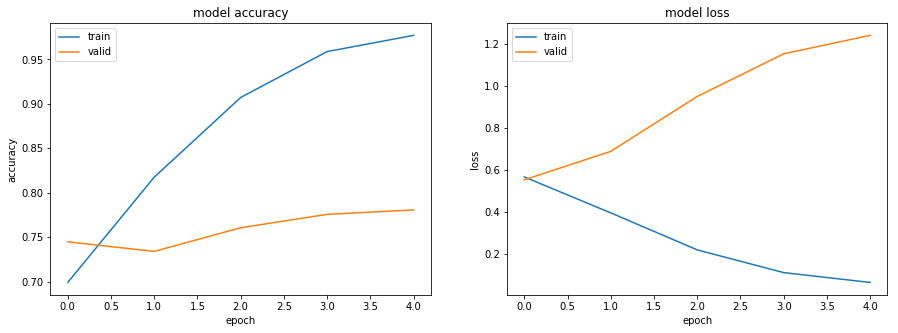

In [21]:
results(history)